# Hydrometeor Viewer

This script displays particle images on a record-by-record basis with the ability to output particle properties based on where the user clicks within the image record. The ability to save selected images to file also exists. Please refer to the readme documentation for usage details.

-----------
Copyright Joseph Finlon, Univ. of Illinois, 2017

In [1]:
import numpy as np
import scipy.misc as smp
import matplotlib as mpl
from matplotlib import colors
from matplotlib.widgets import Button
import matplotlib.pyplot as plt
import xarray as xr
import glob

%matplotlib nbagg

User inputs go here. A few notes:
- campaign: 'olympex', 'pecan', 'gcpex', 'mc3e', 'plows', etc.
- date: 'yyyymmdd' (used for file output path)
- probeName: '2DC', '2DP', 'CIP', 'PIP', '2DS', 'HVPS'
- annotate: 1 - a red asterisk is overlaid every 5 particles (useful for matching w/ PBP data); 0 - no annotations
- imageMode: 0 - all particles shaded black; 1 - rejected particles shaded red
- frameStart: initial frame number to initiate plotting code
- imageFile: file path to decompressed image file (ouput data from read_binary_*.m script)
- partFile: file path to particle-by-particle file (output data from image_proc_sm.m script)

In [2]:
campaign = 'olympex'; date = '20151205'; probeName = 'HVPS'
annotate = 1.; imageMode = 1.; frameStart = 10
imageFile = '/data/gpm/a/shared/finlon2/olympex/munich_workshop/HVPS.20151205_subset.V.cdf'
partFile = '/data/gpm/a/shared/finlon2/olympex/munich_workshop/procHVPS.20151205_subset.V.cdf'

print('Input parameters received! Run the next 3 cell blocks to plot your first image record.')

Input parameters received! Run the next 3 cell blocks to plot your first image record.


Functions to load the particle and image data, & to convert the decimal data to binary.

In [3]:
def get_colors(imageMode):
    if imageMode==0:
        cmap1 = colors.ListedColormap(['black', 'white', 'cyan'])
        bounds = [0,1,2,3]
        norm = colors.BoundaryNorm(bounds, cmap1.N)
        return cmap1, bounds, norm
    elif imageMode==1: # rejected particles (user specifies the conditions) shaded in red
        cmap1 = colors.ListedColormap(['black', 'white', 'cyan', 'red'])
        bounds = [0,1,2,3,4]
        norm = colors.BoundaryNorm(bounds, cmap1.N)
        return cmap1, bounds, norm
    else:
        print('Please select a valid Image Mode.')

def probe_defaults(probeName):
    invalidSlice = np.array([-1., -1., -1., -1., -1., -1., -1., -1.])
    if probeName=='2DS' or probeName=='HVPS':
        boundary = np.array([43690, 43690, 43690, 43690, 43690, 43690, 43690, 43690])
        boundaryTime = 0;
    elif probeName=='CIP' or probeName=='PIP':
        boundary = np.array([170, 170, 170, 170, 170, 170, 170, 170])
        boundaryTime = 0;
        
    return boundary, boundaryTime, invalidSlice

def get_imageData(inFile, frameStart):
    ds = xr.open_dataset(inFile)
    yr = ds['year'][frameStart-1:frameStart][0].values
    mon = ds['month'][frameStart-1:frameStart][0].values
    day = ds['day'][frameStart-1:frameStart][0].values
    hr = ds['hour'][frameStart-1:frameStart][0].values
    minute = ds['minute'][frameStart-1:frameStart][0].values
    sec = ds['second'][frameStart-1:frameStart][0].values
    msec = ds['millisec'][frameStart-1:frameStart][0].values
    data = ds['data'][frameStart-1:frameStart][0].values
    #data = data[0].values
    
    return yr, mon, day, hr, minute, sec, msec, data

def get_slice_endpoints(buf): # get particle slice start/end indices, and the indices for the particle boundary
    numPart = 0 # number of particles in buffer
    startInd = [] # index of the start of a particle
    endInd = [] # index of the end of a particle
    boundaryInd = [] # index of the particle boundary (series of 8 consecutive '43690' values)
    
    j = 0
    while (buf[j,0] != -1) and (j+1 < buf.shape[0]):
        if (np.array_equal(buf[j,:],boundary)) and ((buf[j+1,0]==boundaryTime) or (probeName=='CIP') or
                                                   (probeName=='PIP')): # particle boundary
            boundaryInd.append(j)
            if j>0:
                endInd.append(j-1) # index of particle end before the particle boundary (current particle)
                numPart = numPart + 1 # for particle preceeding boundary
            startInd.append(j+2) # index of particle start after the particle boundary (next particle)
        j = j + 1
    
    boundaryInd = np.array(boundaryInd, dtype='int')
    if (boundaryInd.size>0) or (boundaryInd[0]>0): # no boundaries or first boundary after first slice in buffer
        startInd = np.insert(startInd, 0, 0)
    startInd = np.array(startInd, dtype='int')
    
    if boundaryInd[-1]+3 < buf.shape[0]: # particle occurs after last boundary if it's 3rd from last slice in record
        endInd.append(buf.shape[0]-1) # last particle ends at end of buffer
        endInd = np.array(endInd, dtype='int') 
    else:
        endInd = np.array(endInd, dtype='int') # boundary found at very end of record -- no more particles in buffer
        
    return numPart, boundaryInd, startInd, endInd
               
def get_imageValOffset(imageMode, partStart, partEnd, hr, minute, sec, frameStart, time, frame, partNum, reject,
                       habit, intArr):
    # gathers rejection status or habit data to determine which particles should be shaded a different color/code
    # ** WILL ADD HABIT DISCRIMINATION IN FUTURE RELEASE
    sel_frame = frameStart
    sel_Time = hr*10000 + minute*100 + sec

    partIndices = np.where((time==sel_Time) & (frame==sel_frame))[0]
    numMatches = len(partIndices) # number of particles that meet criteria
    imageValOffset = np.zeros(1700) # initialize offset values for image matrix (== # slices in record)
    
    intArrIndices = intArr[partIndices]
    rejectIndices = reject[partIndices]
    habitIndices = habit[partIndices]
    
    for x in np.arange(numMatches): # loop through particles in record
        if imageMode==1:
            if ((rejectIndices[x]!=48.) and (rejectIndices[x]!=104.) and (rejectIndices[x]!=72.) and
                (rejectIndices[x]!=117.)): # rejected particle (accept code or correctible hollow codes)
                imageValOffset[partStart[x]:partEnd[x]] = 3 # all slices for current value assigned the color RED
                
    return imageValOffset
    
def image_buffer(buf, probeName, boundaryInd, imageValOffset): # generate matrix of 1's and 0's from buffer
    if probeName=='2DS' or probeName=='HVPS':
        boundaryData = np.tile([2,2,1,1], 32) # alternate 1's and 2's for boundary slice (white & cyan pixels)
        buf[buf==-1] = 0 # change invalid values to 0 (unshadowed segment)
        buf = 65535 - buf # 0: shadowed; 1: unshadowed
        
        # convert decimal to binary (8 image words for each slice)
        imageData = np.ones([1700,128]) # set up image buffer (1's mean unshadowed pixels)

        for x in np.arange(buf.shape[0]):
            tempBuf = np.array([np.binary_repr(int(buf[x,0]),16), np.binary_repr(int(buf[x,1]),16),
                                np.binary_repr(int(buf[x,2]),16), np.binary_repr(int(buf[x,3]),16),
                                np.binary_repr(int(buf[x,4]),16), np.binary_repr(int(buf[x,5]),16),
                                np.binary_repr(int(buf[x,6]),16), np.binary_repr(int(buf[x,7]),16)])
            sliceBuf = []
            for y in np.arange((buf.shape[1])*16):
                sliceBuf.append(tempBuf[(np.floor(y/16)).astype(int)][np.mod(y,16)])
            sliceBuf = np.asarray(sliceBuf, dtype='int')
            sliceBuf[sliceBuf==0] = imageValOffset[x]
            imageData[x,:] = sliceBuf
    elif probeName=='CIP' or probeName=='PIP':
        boundaryData = np.tile([2,2,1,1], 16) # alternate 1's and 2's for boundary slice (white & cyan pixels)
        buf[buf==-1] = 255 # change invalid values to 0 (unshadowed segment)
        
        # convert decimal to binary (8 image words for each slice)
        imageData = np.ones([1700,64]) # set up image buffer (1's mean unshadowed pixels)

        for x in np.arange(buf.shape[0]):
            tempBuf = np.array([np.binary_repr(int(buf[x,0]),8), np.binary_repr(int(buf[x,1]),8),
                                np.binary_repr(int(buf[x,2]),8), np.binary_repr(int(buf[x,3]),8),
                                np.binary_repr(int(buf[x,4]),8), np.binary_repr(int(buf[x,5]),8),
                                np.binary_repr(int(buf[x,6]),8), np.binary_repr(int(buf[x,7]),8)])
            sliceBuf = []
            for y in np.arange((buf.shape[1])*8):
                sliceBuf.append(tempBuf[(np.floor(y/8)).astype(int)][np.mod(y,8)])
            sliceBuf[sliceBuf==0.] = imageValOffset[x]
            sliceBuf = np.asarray(sliceBuf, dtype='int')
            imageData[x,:] = sliceBuf

    imageData[boundaryInd,:] = boundaryData # write in boundary slice
    
    if boundaryInd[-1]+1 < buf.shape[0]:
        imageData[boundaryInd+1,:] = 1.
    else:
        imageData[boundaryInd[0:-2]+1,:] = 1.
    
    return(imageData)

def load_partData(inFile, probeName):
    ds1 = xr.open_dataset(inFile)
    # check if rectangular & elliptical fits are part of particle data
    iRecEll = 0
    for varname, da in ds1.data_vars.items():
        if varname=='image_RectangleL':
            iRecEll = 1

    time = (ds1['Time'].values).astype(int)
    frame = (ds1['parent_rec_num'].values).astype(int)
    partNum = (ds1['particle_num'].values).astype(int)
    length = (ds1['image_length'].values).astype(int)
    longestY = (ds1['image_longest_y'].values).astype(int)
    width = (ds1['image_width'].values).astype(int)
    dmax = ds1['image_diam_minR'].values
    if iRecEll==1:
        drec = ds1['image_RectangleL'].values
        dell = ds1['image_EllipseL'].values
    else:
        drec = np.empty(len(time))*np.nan
        dell = np.empty(len(time))*np.nan
    area = ds1['image_area'].values
    perim = ds1['image_perimeter'].values
    reject = ds1['image_auto_reject']
    habit = ds1['holroyd_habit']
    if probeName=='2DS' or probeName=='HVPS':
        tempTime = ds1['Time_in_seconds'] # time in TAS clock cycles
        intArr = np.zeros(len(tempTime.values))
        intArr[1:] = np.diff(tempTime.values) # time difference between particles
    else:
        intArr = ds1['inter_arrival'].values
    
    return time, frame, partNum, length, longestY, width, dmax, drec, dell, area, perim, reject, habit, intArr

def get_partInfo(probeName, position, partStart, partEnd, hr, minute, sec, frameStart, time, frame, partNum, length,
                 longestY, width, dmax, drec, dell, area, perim, reject, habit, intArr):
    global sel_partNum, timeIndex, frameIndex, partNumIndex
    sel_partNum = np.where((pos[0]>=partStart) & (pos[0]<partEnd))
    if len(sel_partNum[0])==0:
        print('You selected a particle boundary. Please click on a particle instead.')
    else:
        sel_partNum = sel_partNum[0][0]+1
        sel_frame = frameStart
        sel_Time = hr*10000 + minute*100 + sec
    
        partIndex = np.where((time==sel_Time) & (frame==sel_frame) & (partNum==sel_partNum))
        indexShape = (np.asarray(partIndex)).shape
        numMatches = indexShape[1] # number of particles that meet criteria (should always equal 1)
        
        timeIndex = time[partIndex]
        frameIndex = frame[partIndex]
        partNumIndex = partNum[partIndex]
        lengthIndex = length[partIndex]
        widthIndex = width[partIndex]
        longestYIndex = longestY[partIndex]
        dmaxIndex = dmax[partIndex]
        drecIndex = drec[partIndex]
        dellIndex = dell[partIndex]
        areaIndex = area[partIndex]
        perimIndex = perim[partIndex]
        intArrIndex = intArr[partIndex]
        rejectIndex = reject[partIndex]
        habitIndex = habit[partIndex]

        rejectNumArray = np.array([48, 97, 65, 116, 112, 104, 72, 115, 122, 102, 105, 117, 85])
        rejectStrArray = ['Not rejected - 0', 'High aspect ratio - a', 'High area ratio - A',
                          'High aspect ratio touching edge - t', 'Low % shadowed area - p', 'Hollow image - h',
                          'Hollow image - H', 'Split image - s', 'Zero area image - z', 'Fake zero area image - f',
                          'Hollow image - i', 'Hollow image - u', 'Hollow image - U']
        for x in np.arange(0,len(rejectNumArray)):
            if rejectNumArray[x]==rejectIndex.values:
                rejectVal = rejectStrArray[x]

        habitNumArray = np.array([77, 67, 116, 111, 108, 97, 103, 115, 104, 105, 100])
        habitStrArray = ['Zero image','Center out','Tiny','Oriented','Linear','Aggregate','Graupel','Spherical',
                         'Hexagonal','Irregular','Dendrite']
        for x in np.arange(0,len(habitNumArray)):
            if habitNumArray[x]==habitIndex.values:
                habitVal = habitStrArray[x]
    
        if numMatches != 1:
            print('Either no particle was found for the specific frame and particle number, or too many were found.\nPlease select different values.')
        elif probeName=='2DS' or probeName=='HVPS':
            print('Time: {}  Frame: {}  Particle: {}\nLength:{:3d}  Width:{:3d}  LongestY:{:3d}\nDmax:{:6.3f} mm  Dmax (Rectangle):{:6.3f} mm  Dmax (Ellipse):{:6.3f} mm\nArea:{:6.3f} mm^2  Perimeter:{:6.3f} mm  Inter-arrival:{:.2e} s\nReject status: {}  Habit: {}'
                  .format(timeIndex[0],frameIndex[0],partNumIndex[0],lengthIndex[0],widthIndex[0],longestYIndex[0],
                          dmaxIndex[0],drecIndex[0],dellIndex[0],areaIndex[0],perimIndex[0],intArrIndex[0],
                          rejectVal,habitVal))
        else: # different formatting of intArr since these data are in xArray's DataArray format and must be converted
            print('Time: {}  Frame: {}  Particle: {}\nLength:{:3d}  Width:{:3d}  LongestY:{:3d}\nDmax:{:6.3f} mm  Dmax (Rectangle):{:6.3f} mm  Dmax (Ellipse):{:6.3f} mm\nArea:{:6.3f} mm^2  Perimeter:{:6.3f} mm  Inter-arrival:{:.2e} s\nReject status: {}  Habit: {}'
                  .format(timeIndex[0],frameIndex[0],partNumIndex[0],lengthIndex[0],widthIndex[0],longestYIndex[0],
                          dmaxIndex[0],drecIndex[0],dellIndex[0],areaIndex[0],perimIndex[0],intArrIndex[0],
                          rejectVal,habitVal))

def annotate_particle_incriments(boundaryInd): # get indices along buffer for every 5 particles (optional plotting)
    partInds = boundaryInd[np.arange(3,(boundaryInd.size)-1, 5)]+1
    
    return partInds

def buffer_integrity(partCount, boundaryInd, partStart, partEnd):
    print('There are {} particles and {} boundaries.'.format(partCount, len(boundaryInd)))
    if np.any(partEnd-partStart<0): # particle end indices NOT >= start indices [ERROR]
        print('Error with particle start/end indices!')
    else:
        print('Particle start/end indices look OK.')

In [4]:
[time, frame, partNum, length, longestY, width, dmax, drec, dell, area, perim, reject, habit, intArr] = load_partData(
    partFile, probeName)

[cmap1, bounds, norm] = get_colors(imageMode)
[boundary, boundaryTime, invalidSlice] = probe_defaults(probeName)
[yr, mon, day, hr, minute, sec, msec, data] = get_imageData(imageFile, frameStart)
[partCount, boundaryInd, partStart, partEnd] = get_slice_endpoints(data)
if imageMode==0:
    imageValOffset = np.zeros(1700)
else:
    imageValOffset = get_imageValOffset(imageMode, partStart, partEnd, hr, minute, sec, frameStart, time, frame,
                                        partNum, reject, habit, intArr)
img = image_buffer(data, probeName, boundaryInd, imageValOffset)

frameNo = frameStart

Plot image record, with abiliy to select a particlular particle or to advance/rewind frame by frame.

<IPython.core.display.Javascript object>


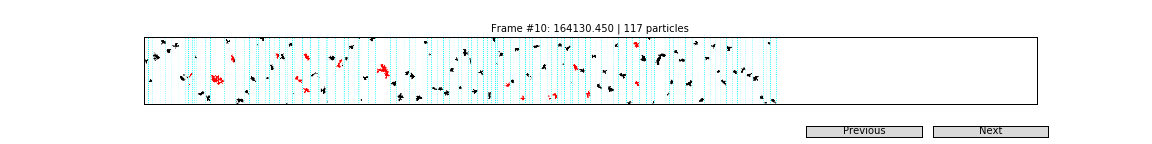

In [5]:
pos = []
def onclick(event):
    global pos
    pos = [event.xdata, event.ydata]

fig, ax = plt.subplots(1, figsize=(16,2))
implot = ax.imshow((img[0:1700,:]).T, cmap=cmap1, norm=norm)
titleStr = 'Frame #{}: {:02d}{:02d}{:02d}.{:03d} | {} particles'.format(frameStart, int(hr), int(minute), int(sec),
                                                                        int(msec), partCount)
ax.set_title(titleStr, size=10)
ax.set_xticks([]), ax.set_yticks([])
fig.canvas.mpl_connect('button_press_event', onclick)

class Index(object):
    ind = frameStart
    def next(self, event):
        global frameNo, hr, minute, sec, boundaryInd, partStart, partEnd, imageMode, imageValOffset, img
        self.ind += 1
        frameNo = self.ind
        [yr, mon, day, hr, minute, sec, msec, data] = get_imageData(imageFile, frameNo)
        [partCount, boundaryInd, partStart, partEnd] = get_slice_endpoints(data)
        if imageMode==0:
            imageValOffset = np.zeros(1700)
        else:
            imageValOffset = get_imageValOffset(imageMode, partStart, partEnd, hr, minute, sec, frameNo,
                                                time, frame, partNum, reject, habit, intArr)
        img = image_buffer(data, probeName, boundaryInd, imageValOffset)
        implot = ax.imshow((img[0:1700,:]).T, cmap=cmap1, norm=norm)
        titleStr = 'Frame #{}: {:02d}{:02d}{:02d}.{:03d} | {} particles'.format(frameNo, int(hr), int(minute),
                                                                                int(sec), int(msec), partCount)
        ax.set_title(titleStr, size=10)
        plt.draw()
        return frameNo
    def prev(self, event):
        global frameNo, hr, minute, sec, boundaryInd, partStart, partEnd, imageMode, imageValOffset, img
        self.ind -= 1
        frameNo = self.ind
        [yr, mon, day, hr, minute, sec, msec, data] = get_imageData(imageFile, frameNo)
        [partCount, boundaryInd, partStart, partEnd] = get_slice_endpoints(data)
        if imageMode==0:
            imageValOffset = np.zeros(1700)
        else:
            imageValOffset = get_imageValOffset(imageMode, partStart, partEnd, hr, minute, sec, frameNo,
                                                time, frame, partNum, reject, habit, intArr)
        img = image_buffer(data, probeName, boundaryInd, imageValOffset)
        implot = ax.imshow((img[0:1700,:]).T, cmap=cmap1, norm=norm)
        titleStr = 'Frame #{}: {:02d}{:02d}{:02d}.{:03d} | {} particles'.format(frameNo, int(hr), int(minute),
                                                                                int(sec), int(msec), partCount)
        ax.set_title(titleStr, size=10)
        plt.draw()
        return frameNo

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)
plt.show()

Display selected particle properties.

In [6]:
get_partInfo(probeName, pos, partStart, partEnd, hr, minute, sec, frameNo, time, frame, partNum, length, longestY,
             width, dmax, drec, dell, area, perim, reject, habit, intArr)

Time: 164130  Frame: 10  Particle: 17
Length: 15  Width: 11  LongestY:  8
Dmax: 2.371 mm  Dmax (Rectangle):   nan mm  Dmax (Ellipse):   nan mm
Area: 1.755 mm^2  Perimeter: 6.600 mm  Inter-arrival:3.20e-04 s
Reject status: Hollow image - h  Habit: Irregular


Save image of selected particle to file.

In [7]:
img_sub = np.array(img[partStart[sel_partNum-1]:partEnd[sel_partNum-1]+1,:], dtype=np.byte)
image = smp.toimage(img_sub.T, mode='L')
outFile = '/data/gpm/a/shared/finlon2/{}/munich_workshop/images/{}.{}.{}_{}.png'.format(campaign, probeName,
                                                                                        timeIndex[0], frameIndex[0],
                                                                                        partNumIndex[0])
image.save(outFile)
print('Particle saved out to file: {}'.format(outFile))

Particle saved out to file: /data/gpm/a/shared/finlon2/olympex/munich_workshop/images/HVPS.164130.10_17.png
